The codes have commented the ones thta applying the simple classifiers, as LR and NB, to the datasets with the pretrained word embeddings.

In [1]:

import pandas as pd
import numpy as np
import re, string
import matplotlib.pyplot as plt
import transformers
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import seaborn as sns
import torch
import gensim
from gensim.models import Word2Vec


[nltk_data] Downloading package punkt to /home/amber/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/amber/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/amber/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/amber/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('Freedom_Convoy.csv', index_col=0)


In [3]:
df = df[df['body'].notnull()]
df

,body,sentiment_category
0,The only comment I have is that people should ...,NEG
1,Honestly I just wish everyone would stop givin...,NEG
2,Yes. I’m starting to miss all those posts for ...,NEG
3,Imagine creating new accounts to feed anti vac...,NEG
4,"I’m still good to complain about them, right?",NEU
...,...,...
130152,Just being neighbourly!,NEU
130153,I just recently heard that “sunshine” from 302...,NEU
130154,"They are free to do this, its not like people ...",NEU
130155,I hope some of them do so they get charged. Wi...,NEG


##Data Cleaning

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130156 entries, 0 to 130156
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   body                130156 non-null  object
 1   sentiment_category  130156 non-null  object
dtypes: object(2)
memory usage: 3.0+ MB


<AxesSubplot:xlabel='sentiment_category', ylabel='count'>

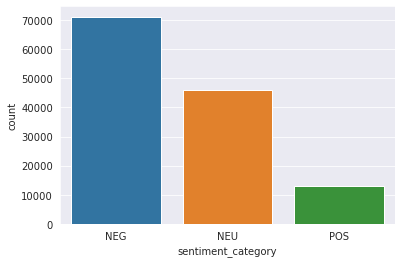

In [5]:
sns.countplot(df['sentiment_category'])

In [6]:
df['word_count'] = df['body'].apply(len)
df['word_count'].describe()

count    130156.000000
mean        130.901288
std         182.985155
min           7.000000
25%          47.000000
50%          84.000000
75%         151.000000
max        9324.000000
Name: word_count, dtype: float64

<AxesSubplot:>

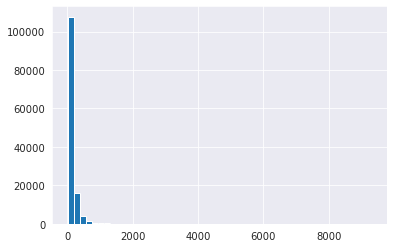

In [7]:
df['word_count'].hist(bins=50)

In [8]:
# g = sns.FacetGrid(df,col='sentiment_category')
# g.map_dataframe(sns.histplot,'word_count', binrange=(0, 2000))

<AxesSubplot:xlabel='word numbers', ylabel='# of moments'>

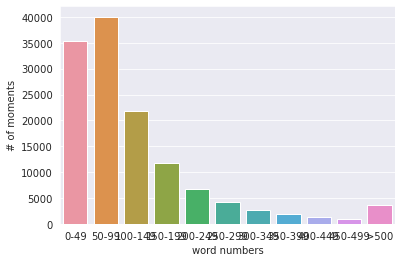

In [9]:
length_order = ["0-49", "50-99", "100-149", "150-199", "200-249", "250-299", "300-349", "350-399", "400-449", "450-499",">500"]
length_category = df['word_count'].apply(lambda x: length_order[min(10, int(x/50))])
length_counts = pd.DataFrame(length_category.value_counts()).reset_index()
length_counts.columns = ['word numbers', '# of moments']

sns.barplot(x='word numbers', y='# of moments', data=length_counts, order=length_order)

In [10]:
df['body'][df['word_count'] == 9324]

86063    * Fleury: Thanks businesses, local residents. ...
Name: body, dtype: object

In [11]:
y= pd.get_dummies(df['sentiment_category']).values
num_classes = df['sentiment_category'].nunique()
np.array(y)

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

In [12]:
#df['labels'] = df['']

In [13]:
# convert the original data to lowercase, strip and remove punctuations
def clean_text(text):
    text = text.lower()
    text=text.strip()
    text=re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\[[0-9]*\]',' ',text)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text)
    text = re.sub(r'\s+',' ',text)
    return text

# Lexicon - based
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)#LEMMATIZATION
# Initialize the lemmatizer

# #2. STEMMING
# # Initialize the stemmer
# snow = SnowballStemmer('english')
# def stemming(string):
#     a=[snow.stem(i) for i in word_tokenize(string) ]
#     return " ".join(a)

# 3.
wl = WordNetLemmatizer()
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN# Tokenize the sentence
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [14]:
def finalpreprocess(string):
    return lemmatizer(stopword(clean_text(string)))
df['clean_text'] = df['body'].apply(lambda x: finalpreprocess(x))
df.head()

,body,sentiment_category,word_count,clean_text
0,The only comment I have is that people should ...,NEG,502,comment people actually read protest trucker p...
1,Honestly I just wish everyone would stop givin...,NEG,174,honestly wish everyone would stop give loser a...
2,Yes. I’m starting to miss all those posts for ...,NEG,86,yes im start miss post every time bus get stic...
3,Imagine creating new accounts to feed anti vac...,NEG,58,imagine create new account fee anti vacc garbage
4,"I’m still good to complain about them, right?",NEU,45,im still good complain right


TRAIN TEST SPLITTING OF LABELLED DATASET

In [15]:
df

,body,sentiment_category,word_count,clean_text
0,The only comment I have is that people should ...,NEG,502,comment people actually read protest trucker p...
1,Honestly I just wish everyone would stop givin...,NEG,174,honestly wish everyone would stop give loser a...
2,Yes. I’m starting to miss all those posts for ...,NEG,86,yes im start miss post every time bus get stic...
3,Imagine creating new accounts to feed anti vac...,NEG,58,imagine create new account fee anti vacc garbage
4,"I’m still good to complain about them, right?",NEU,45,im still good complain right
...,...,...,...,...
130152,Just being neighbourly!,NEU,23,neighbourly
130153,I just recently heard that “sunshine” from 302...,NEU,94,recently hear sunshine coventry resign idea mean
130154,"They are free to do this, its not like people ...",NEU,109,free like people object protest protest
130155,I hope some of them do so they get charged. Wi...,NEG,100,hope get charge luck cop stand checking


In [16]:
from sklearn.model_selection import train_test_split
X_train, x_test, Y_train, y_test = train_test_split(df["clean_text"], y, test_size=0.2,shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2,shuffle=True)

print(len(x_train),len(x_test),len(x_val))

83299 26032 20825


3). Logistic Regression with Word2Vec

Tokenized with Bert

In [17]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)#, model_max_length=512)


In [18]:
# Concatenate train data and test data
all_text = df.body.values
# Encode our concatenated data
encoded_text = [tokenizer.encode(i, add_special_tokens=True) for i in all_text]
#print(encoded_text)
embed_vocab = {}
for word in tokenizer.vocab.keys():
    embed_vocab[word] = True
#print(len(embed_vocab))
# Find the maximum length
max_len = max([len(i) for i in encoded_text])
print('Max length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (1016 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (653 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (825 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1182 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Max length:  1973


In [19]:
text = df['clean_text']
text_words = []
text_vocab = {}
for string in text:
    # Don't include words that can't actually be mapped to a vector using embeddings
    words = string.split()
    filtered_words = []
    for word in words:
        text_vocab[word] = True
        if embed_vocab.get(word) is not None:
            filtered_words.append(word)
    text_words.append(filtered_words)

In [20]:
# print(text_words)

In [21]:
def vocab_coverage(compared, base):  #, k):
    hit, miss = 0, 0
    for word in compared:
        if base.get(word) is not None:
            hit += 1
        else:
            miss += 1
            #base[word] = np.random.uniform(-0.25, 0.25, k)
    print("{} words were found".format(hit))
    print("{} words weren't found".format(miss))
    #print("new length of {} word_vectors".format(len(embed_vocab)))

vocab_coverage(text_vocab, embed_vocab)  # , 300)

12785 words were found
23143 words weren't found


In [22]:
def preprocessing_data(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    MAX_LEN = 128

    # For every sentence...
    for i in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text = i ,  # Preprocess sentence
            add_special_tokens=False,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=False      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))

    # # Convert lists to tensors
    # input_ids = torch.tensor(input_ids)
    # attention_masks = torch.tensor(attention_masks)

    return input_ids



In [23]:
#prepare input under agency/sociality/combined class
train_inputs = preprocessing_data(x_train)
val_inputs = preprocessing_data(x_val)
test_inputs = preprocessing_data(x_test)
#


In [24]:
# test_inputs = preprocessing_data(df['clean_text'])

Basic classifiers under Bert tokenizer

In [25]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64
print(type(y_train))

datasets = {
    'train': TensorDataset(torch.tensor(train_inputs), torch.tensor(y_train)),
    'val': TensorDataset(torch.tensor(val_inputs),  torch.tensor(y_val)),
    'test': TensorDataset(torch.tensor(test_inputs),  torch.tensor(y_test)),

}
print(datasets['train'])
dataloaders = {
    'train': DataLoader(datasets['train'], batch_size=batch_size),
    'val': DataLoader(datasets['val'], batch_size=batch_size),
    'test': DataLoader(datasets['test'], batch_size=batch_size),
}

<class 'numpy.ndarray'>


2. [30 marks] Train an advanced classifier based on deep learning, such as fine-tuning BERT. You can try predicting both labels independently, or in a multi-task manner. Use part of the training data for validation, and keep aside the test data when choosing the best model.


In [26]:

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the GPU")
else:
    device = torch.device("cpu")
    print("running on the CPU")


running on the GPU


In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class SentimentCNN(nn.Module):
    """
    The embedding layer + CNN model that will be used to perform sentiment analysis.
    """

    def __init__(self, embed_model, vocab_size, output_size, embedding_dim, num_filters=100, kernel_sizes=[2, 4, 7], freeze_embeddings=True, drop_prob=0.2):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentCNN, self).__init__()

        # set class vars
        self.num_filters = num_filters
        self.embedding_dim = embedding_dim

        # 1. embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # set weights to pre-trained
        #self.embedding.weight = nn.Parameter(torch.from_numpy(embed_model.vectors)) # all vectors
        # (optional) freeze embedding weights
        if freeze_embeddings:
            self.embedding.requires_grad = False

        # 2. convolutional layers
        self.convs_1d = nn.ModuleList([
            nn.Conv2d(1, num_filters, (k, embedding_dim), padding=(k-2, 0))
            for k in kernel_sizes])

        # 3. final, fully-connected layer for classification
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, output_size)

        # 4. dropout and sigmoid layers
        self.dropout = nn.Dropout(drop_prob)
        self.act = nn.Softmax(dim=-1)

    def conv_and_pool(self, x, conv):
        """
        Convolutional + max pooling layer
        """
        # squeeze last dim to get size: (batch_size, num_filters, conv_seq_length)
        # conv_seq_length will be ~ 500
        x = F.relu(conv(x)).squeeze(3)

        # 1D pool over conv_seq_length
        # squeeze to get size: (batch_size, num_filters)
        x_max = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x_max

    def forward(self, x):
        """
        Defines how a batch of inputs, x, passes through the model layers.
        Returns a single, sigmoid-activated class score as output.
        """
        # embedded vectors
        embeds = self.embedding(x) # (batch_size, seq_length, embedding_dim)
        # embeds.unsqueeze(1) creates a channel dimension that conv layers expect
        embeds = embeds.unsqueeze(1)

        # get output of each conv-pool layer
        conv_results = [self.conv_and_pool(embeds, conv) for conv in self.convs_1d]

        # concatenate results and add dropout
        x = torch.cat(conv_results, 1)
        x = self.dropout(x)

        # final logit
        logit = self.fc(x)

        # # sigmoid-activated --> a class score
        output = self.act(logit)

        return output
from transformers import get_linear_schedule_with_warmup


def initialize_model(device, epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate model
    vocab_size = len(embed_vocab)
    output_size = 3
    embedding_dim = 300
    num_filters = 100
    kernel_sizes = [2, 4, 7]

    net = SentimentCNN(tokenizer, vocab_size, output_size, embedding_dim,
                   num_filters, kernel_sizes)

    # Tell PyTorch to run the model on GPU
    if device:
        net.to(torch.device("cuda:0"))

    # Create the optimizer
    lr=0.001
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    # Total number of training steps
    total_steps = len(dataloaders['train']) * epochs

    # # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return net, optimizer, scheduler
import numpy as np
import torch.nn as nn
import torch
import random
criterion = nn.CrossEntropyLoss()
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []
    # nonacc = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        inputs, labels = tuple(t.to(torch.device("cuda:0")) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(inputs)

        # Compute loss
        loss = criterion(logits, labels.float())
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.round(logits)
        p = (preds - labels).cpu().numpy()
        num = np.count_nonzero(p, axis = 1)
        zero_num = num == 0

        # Calculate the accuracy rate
        accuracy = zero_num.mean()
        #accuracy =
        # non = (preds != labels).cpu().numpy()
        # nonacc.append(non)
        #print("acc:",accuracy)
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    # print(nonacc)

    return val_loss, val_accuracy

# training loop
def train(model, train_loader, val_dataloader=None, epochs=4, evaluation=False):
    device=torch.cuda.is_available()
    if(device):
        net.cuda()

    counter = 0 # for printing
    # Print the header of the result table
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} ")
    print("-"*70)

    #min_loss = np.Inf
    # train for some number of epochs
    #net.train()
    for i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        total_loss, batch_loss = 0, 0
        net.train()

        # batch loop

        for step, batch in enumerate(train_loader):
            counter +=1
            # Load batch to GPU
            if(device):
                inputs, labels = tuple(t.to(torch.device("cuda:0")) for t in batch)
                inputs, labels = inputs.cuda(), labels.cuda()

            # zero accumulated gradients
            net.zero_grad()
            # get the output from the model
            output = net(inputs)
            #y = torch.softmax(output, dim=1)

            loss = criterion(output, labels.float())
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()
            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()



        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_loader)

        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
             # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data


            print(f"{i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f}")


    print("Training complete!")

set_seed(42)    # Set seed for reproducibility
net, optimizer,scheduler = initialize_model(device, epochs=2)
train(net, dataloaders['train'], dataloaders['val'], epochs=4, evaluation=True)

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  
----------------------------------------------------------------------
   1    |    -    |   0.895622   |  0.869465  |   0.67   
   2    |    -    |   0.826196   |  0.859147  |   0.68   
   3    |    -    |   0.796596   |  0.861152  |   0.68   
   4    |    -    |   0.797327   |  0.858922  |   0.68   
Training complete!


In [31]:
# torch.cuda.memory_stats()

In [32]:
import torch.nn.functional as F

def cnn_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []
    all_labels = []
    test_loss = []
    test_accuracy = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        if(device):
            inputs, labels = tuple(t.to(torch.device("cuda:0")) for t in batch)
            inputs, labels = inputs.cuda(), labels.cuda()

        # Compute logits
        with torch.no_grad():
            logits = model(inputs)
        #pred = torch.round(logits)
        all_labels.append(labels)
        all_logits.append(pred)
        # Compute loss
        loss = criterion(logits, labels.float())
        test_loss.append(loss.item())

        # Get the predictions
        preds = torch.round(logits)

        p = (preds - labels).cpu().numpy()
        num = np.count_nonzero(p, axis = 1)
        zero_num = num == 0

        # Calculate the accuracy rate
        accuracy = zero_num.mean()
        #print("test:", accuracy)
        test_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    test_loss = np.mean(test_loss)
    test_accuracy = np.mean(test_accuracy)

    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    all_logits = all_logits.to("cpu").detach().numpy()
    all_labels = all_labels.to("cpu").detach().numpy()

    # Apply softmax to calculate probabilities
    #probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return all_logits,all_labels, test_loss, test_accuracy



# Compute predicted probabilities on the test set
probs, labels, test_loss, test_accuracy = cnn_predict(net, dataloaders['test'])
print(f'Acc: {test_accuracy:^.2f}, Loss: {test_loss:^10.6f} ')
c_report = classification_report(labels, probs, target_names=['NEU', 'NEG', 'POS'])
print(c_report)

<ipython-input-27-22499ce0d343>:73: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.act(logit)


NameError: name 'pred' is not defined

In [ ]:
# print(type(probs))
# print(type(labels))

In [ ]:
# print(type(probs.astype(int)))

In [ ]:
pred = np.argmax(probs, axis=1)
# label
y_train = np.argmax(labels, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
def get_confusion_matrix(trues, preds):
  labels = [0,1,2]
  conf_matrix = confusion_matrix(y_true= trues, y_pred = preds, labels = labels)
  return conf_matrix
def plot_confusion_matrix(conf_matrix):
  plt.imshow(conf_matrix, cmap=plt.cm.Blues_r)
  indices = range(conf_matrix.shape[0])
  labels = [0, 1,2]
  plt.xticks(indices, labels)
  plt.yticks(indices, labels)
  plt.colorbar()
  plt.xlabel('y_pred')
  plt.ylabel('y_true')
  # 显示数据
  for first_index in range(conf_matrix.shape[0]):
    for second_index in range(conf_matrix.shape[1]):
      plt.text(first_index, second_index, conf_matrix[first_index, second_index])
  plt.savefig('heatmap_confusion_matrix.jpg')
  plt.show()

conf_matrix = get_confusion_matrix(y_train, pred)
print(conf_matrix)

In [ ]:
plot_confusion_matrix(conf_matrix)

In [ ]:
probs = list(probs)

def multi_indicator(probs):
    int_probs = []
    probs_i = []
    for i in probs:
        for j in i:
            j =int(j)
            int_probs.append(j)
        probs_i.append(int_probs)
        int_probs = []
    return probs_i

probs_i = multi_indicator(probs)
probs_i


In [ ]:
labels = multi_indicator(labels)
labels

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

def plot_roc(y_score, y_label):
    n_classes = len(y_score[0])

    # 计算每一类的ROC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_label[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # micro
    fpr["micro"], tpr["micro"], _ = roc_curve(y_label.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # macro
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    lw=2
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('multi-calss ROC')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
plot_roc(np.array(probs_i), np.array(labels))